# An intro to Gaussian Processes: Implementing a Basic GP From Scratch

### Introduction

Welcome to this introduction to Gaussian Processes (GPs)! GPs provide some powerful tools for conducting inference, and bring a lot to the table that many other machine learning simply are unable to. Namely, GPs can model complex functions, making them extremely flexible, as well as track our uncertainty at all time.

note: for the purpose of this exercise, when I reference *GPs*, I am specifically talking about 1-D GPs

A GP is completely defined by its mean function (which we will assume to be zero) and its kernel function. For the kernel function, we will implement the basic Squared Exponential Kernel.

### Lets borrow some code

In [1]:
using Random, Distributions, LinearAlgebra, Plots
rng = Random.seed!(1234)

MersenneTwister(1234)

### The Data

We will start off by making our toy dataset, by adding some noise to a nonlinear function.

In [2]:
x = range(0,30;length=40)

0.0:0.7692307692307693:30.0

In [3]:
ϵ = rand(Normal(0,0.5), 40);
y = sqrt.(x).*sin.(x) .+ ϵ;

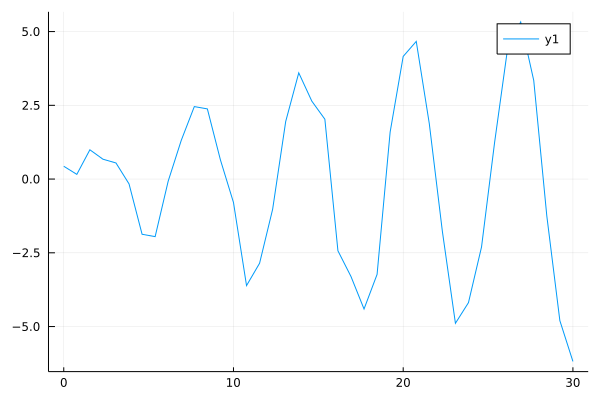

In [4]:
plot(x,y)

In [5]:
indices =  randcycle(rng, 40)
x_train = zeros(30)
y_train = zeros(30)
x_test = zeros(10)
y_test = zeros(10)
for (i, val) in enumerate(indices)
    if i<=30
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-30] = x[val]
        y_test[i-30] = y[val]
    end
end

We now have split our data to isolate some training data, as well as some unseen data. We are calling this unseen data "test" data, however it may be more appropriate to imagine it as data we may want to make predictions on later.

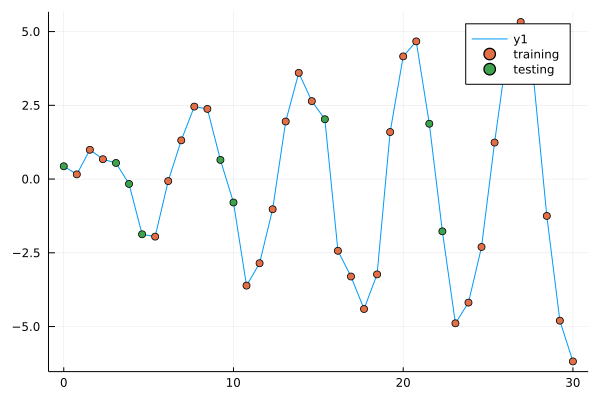

In [6]:
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

### The Building Blocks

We assume our mean to be zero so all we need to do is build our kernel function that will be used to construct our covariance matrix. As mentioned above we are using the Squared Exponential kernel. This kernel has two parameters, giving our model two hyperparameters. Given this is just a basic intro, we won't be worrying about these.

In [7]:
function SE_kernel(x, x′; σ=1, ℓ=1)
    return (σ^2)*exp(-0.5*(x-x′)^2/ℓ)
end

SE_kernel (generic function with 1 method)

### Define a GP in Julia

In [8]:
struct GP
    # mean = 0
    kernel
end

In [9]:
gp = GP(SE_kernel)

GP(SE_kernel)

### Construct a Covariance Matrix and Cross-Covariance Matrix

While these could very well have just been a single method, I separated them into two to take advantage of the symmetry found in covariance matrices to minimize some computation.

In [10]:
function cov_mat(gp::GP, xs)
    len = length(xs)
    K = zeros(len,len)
    for i in 1:len
        for j in i:len
            K[i,j] = gp.kernel(xs[i],xs[j])
            K[j,i] = K[i,j]
        end
    end
    # we add noise to ensure positive definiteness
    σ = 1e-6
    return K + σ*I
end

cov_mat (generic function with 1 method)

In [11]:
function x_cov_mat(gp::GP, X, X′)
    size= length(X)
    size′= length(X′)
    K =zeros(size,size′)
    for i in 1:size
        for j in 1:size′
            K[i,j] = gp.kernel(X[i],X′[j])
        end
    end
    # we add noise to ensure positive definiteness
    return K
end

x_cov_mat (generic function with 1 method)

### Prior

Here we build a method to draw samples from the prior distribution

In [12]:
function sample_prior(xs, num_samples, gp)
    Σ = cov_mat(gp, xs)
    μ = zeros(length(Σ[1,:]))
    ys = rand(MvNormal(μ, Σ), num_samples)
    plot(xs, ys)
end

sample_prior (generic function with 1 method)

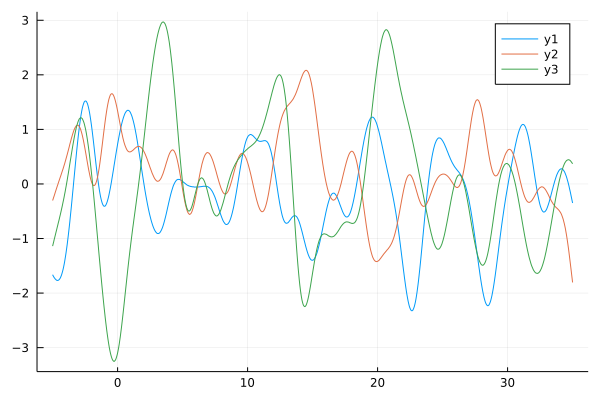

In [13]:
xs = range(-5, 35; length=1000)
sample_prior(xs, 3, gp)

### Posterior

We now build some functionality for computing the posterior gp as well as some other valuable measures.

In [14]:
function posterior(K, y)
    return (1/(det(2*π*K)))*exp((-0.5)*transpose(y)*inv(K)*y)
end

posterior (generic function with 1 method)

In [15]:
function log_pdf(K, y)
    return log(posterior(K, y))
end

log_pdf (generic function with 1 method)

### Posterior GP and sampler

Given our posterior GP will have a mean vector and covariance matrix, rather than tracking these individually and separately, we will define a new object to contain this information.

In [16]:
struct post_GP
    μ
    Σ
end

We start with a very naive implementation of computing the posterior GP. Later I will add more efficient and numerically sound methods, hopefully comparing the results to highlight the benefits to taking advantage of interesting properties of our covariance matrix, such as Cholesky factorizations or QR factorizations.

In [17]:
function posterior_gp(x_train, y_train, x_pred, gp)
    Σ_11 = cov_mat(gp, x_train)
    Σ_12 = x_cov_mat(gp, x_train, x_pred)
    Σ_22 = cov_mat(gp, x_pred)
    temp = transpose(inv(Σ_11)*Σ_12) # not stable
    μ_post = temp*y_train
    Σ_post = Σ_22 - temp * Σ_12
    return post_GP(μ_post, Symmetric(Σ_post)) # Symmetric required due to some numeric instability of the above operations
end

posterior_gp (generic function with 1 method)

Our sampler can return multiple samples from the posterior (each sample will be a realization of our posterior GP) that include their standard deviations as a ribbon.

In [18]:
function sample_posterior(x_train, y_train, x_test, num_samples, gp)
    post_GP = posterior_gp(x_train, y_train, x_test, gp)
    ys = rand(MvNormal(post_GP.μ, post_GP.Σ), num_samples)
    σs = sqrt.(diag(post_GP.Σ))
    return ys, σs
end

sample_posterior (generic function with 1 method)

### Making Predictions

We now make a function to execute predictions for specified inputs that weren't available at training (so previously unseen data).

In [19]:
function predict(x_train, y_train, x_pred, x_start, x_end, gp; interval_length=1000)
    xs = sort(union(range(x_start, x_end; length = interval_length), x_pred))
    post_GP = posterior_gp(x_train, y_train, xs, gp)
    ys = rand(MvNormal(post_GP.μ, post_GP.Σ))
        y_pred = []
    for i in 1:length(xs)
        if xs[i] in x_pred
            append!(y_pred, ys[i])
        end
    end
    return y_pred
end

predict (generic function with 1 method)

In [20]:
p_GP = posterior_gp(x_train, y_train, x_test, gp)

post_GP([-1.434624165535355, -2.5153695963910563, -2.3618038769426577, -0.02221671721659449, 2.978180069075897, -0.3028174363097979, 2.6090637530565455, -2.648244770549548, -0.5081911126271192, 0.11102780002510748], [0.6226086423659302 0.32166346181561634 … -0.06338544020440644 -0.02771298542922322; 0.32166346181561634 0.2132029488074515 … -0.016069973074392604 -0.03171354565687799; … ; -0.06338544020440644 -0.016069973074392604 … 0.25732079109144024 0.00047081499940262246; -0.02771298542922322 -0.03171354565687799 … 0.00047081499940262246 0.13061371839258895])

In [21]:
x_pred = range(-5, 35; length=1000)
y_pred, σ_pred = sample_posterior(x_train, y_train, x_pred, 3, gp)

([1.3289380852663242 0.22015815992699975 -0.19166089524007252; 1.3524166942049423 0.2622961384828488 -0.20994243941484544; … ; 0.782229783253359 -0.2602037399616343 -1.2079087029391025; 0.7331099035644082 -0.28884940099252887 -1.1539571333849286], [1.0000004999998695, 1.0000004999998662, 1.000000499999861, 1.000000499999853, 1.0000004999998409, 1.0000004999998215, 1.0000004999997916, 1.0000004999997456, 1.0000004999996746, 1.0000004999995655  …  1.0000004992518958, 1.0000004994840217, 1.0000004996452663, 1.0000004997569012, 1.0000004998339325, 1.00000049988691, 1.0000004999232237, 1.0000004999480328, 1.0000004999649257, 1.0000004999763903])

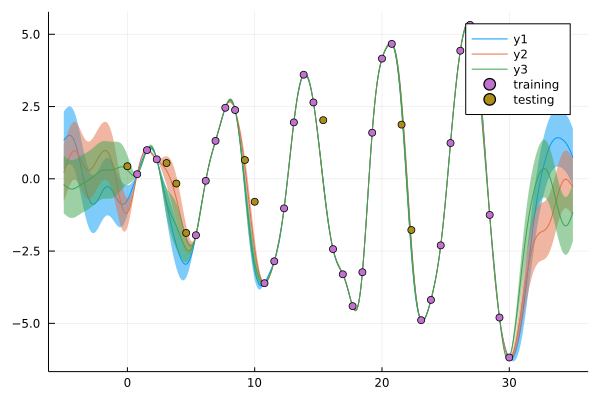

In [22]:
plot(x_pred, y_pred, ribbon=σ_pred)
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

Testing the training method.

In [23]:
x_pred = [0, 1, 10, 11, 12, 20, 25, 29, 34]
y_pred = predict(x_train, y_train, x_pred, 0, 35, gp)

9-element Vector{Any}:
 -0.4242939370263714
  0.47906043412043864
 -3.096118871200501
 -3.4481723791326515
 -1.967755396222548
  4.157755567550688
 -0.6707251158771252
 -3.86567701393966
  1.0280126679442363

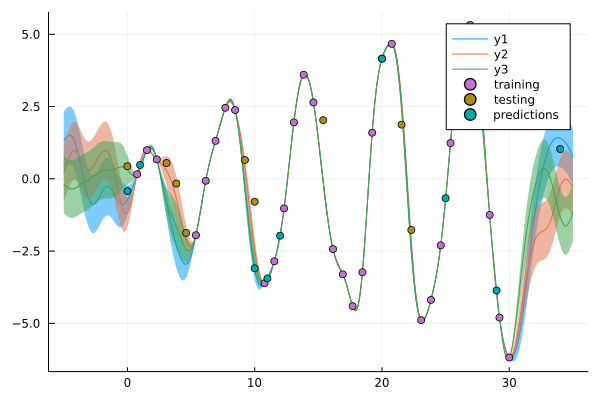

In [24]:
scatter!(x_pred, y_pred, label = "predictions")

### Trying a different (and much more quickly varying) target function

We edit the (hardcoded) hyperparameters of our kernel function to better match our assumptions/knowledge about the function we are trying to model.

In [25]:
function SE_kernel_2(x, x′; σ=1, ℓ=0.001)
    return (σ^2)*exp(-0.5*(x-x′)^2/ℓ)
end

SE_kernel_2 (generic function with 1 method)

In [26]:
gp_2 = GP(SE_kernel_2)

GP(SE_kernel_2)

In [27]:
x = range(0,1;length=40)

0.0:0.02564102564102564:1.0

In [28]:
ϵ = rand(Normal(0,0.5), 40);
y = ℯ.^(x) - 3*tan.(x) .+ ϵ;

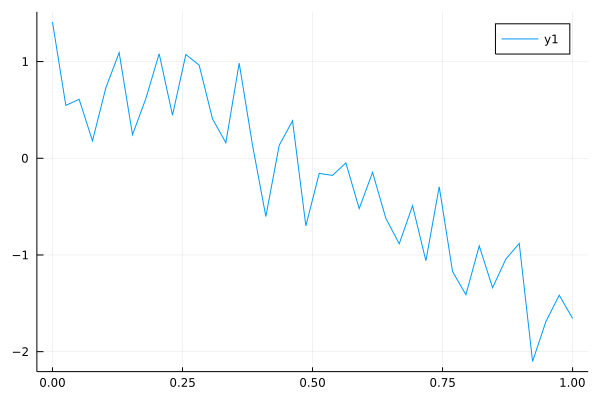

In [29]:
plot(x,y)

In [30]:
indices =  randcycle(rng, 40)
x_train = zeros(30)
y_train = zeros(30)
x_test = zeros(10)
y_test = zeros(10)
for (i, val) in enumerate(indices)
    if i<=30
        x_train[i] = x[val]
        y_train[i] = y[val]
    else
        x_test[i-30] = x[val]
        y_test[i-30] = y[val]
    end
end

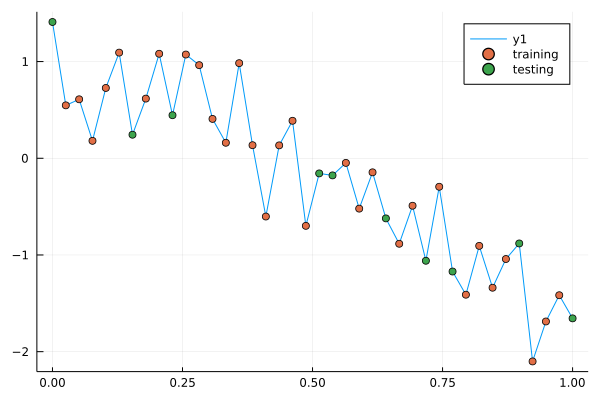

In [31]:
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

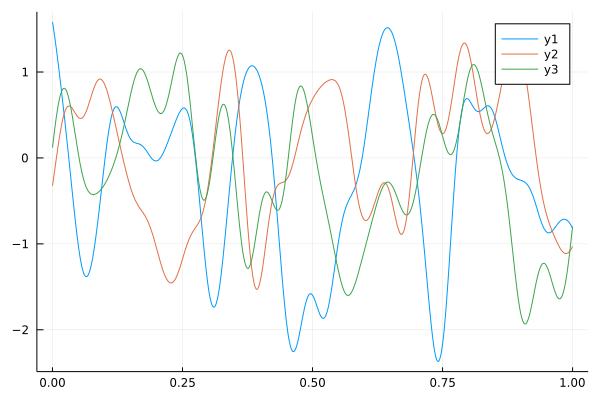

In [32]:
xs = range(0,1;length=1000)
sample_prior(xs,3,gp_2)

In [33]:
p_GP2 = posterior_gp(x_train, y_train, x_test, gp_2)

post_GP([-0.2957400968310338, 0.13787422384849685, -0.9705917301030412, -0.04826056019406941, -1.3441691614273843, -0.02209173077483821, 1.2934313207837271, 0.6566042413348582, -1.1633492353800647, -1.4585599689386548], [0.05765117540446807 0.03935037542338778 … 0.00038225912817406167 -0.013650452642590075; 0.03935037542338778 0.09613344349581077 … 0.002371552018070293 -0.06212589185409745; … ; 0.00038225912817406167 0.002371552018070293 … 0.29522042937405457 -0.006008300049752829; -0.013650452642590075 -0.06212589185409745 … -0.006008300049752829 0.07637494167907621])

In [34]:
x_pred = range(0, 1; length=1000)
y_pred, σ_pred = sample_posterior(x_train, y_train, x_pred, 3, gp_2)

([-0.05412223993326585 -0.6366630988588035 0.7183195880522208; -0.03964828911589475 -0.6033544403500525 0.7077469371736643; … ; -0.7814638711134911 -1.1754215233072127 -1.4403485342937934; -0.7538893705968723 -1.1365438605349767 -1.4177017465520636], [0.5190405136139301, 0.49588570397769977, 0.4724643013571987, 0.4488336532813506, 0.4250538295021339, 0.4011873307714866, 0.37729876846349236, 0.3534545167200185, 0.3297223391247713, 0.3061709922325767  …  0.3286966823552353, 0.35285300858305035, 0.3770833038861146, 0.40131987220061927, 0.4254967766781962, 0.4495501767038702, 0.47341863871179884, 0.4970434192864952, 0.5203687193285752, 0.5433419083542651])

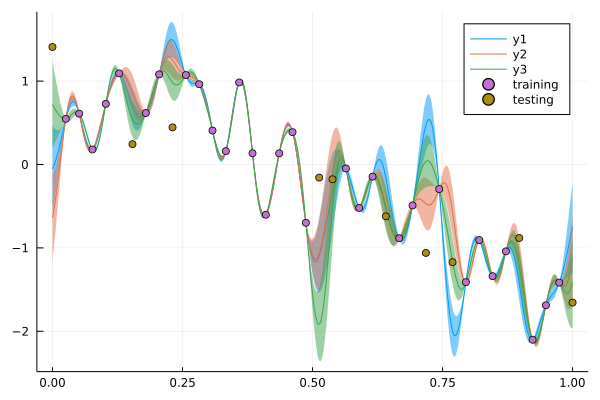

In [35]:
plot(x_pred, y_pred, ribbon=σ_pred)
scatter!(x_train ,y_train,label="training")
scatter!(x_test ,y_test,label="testing")

In [36]:
x_pred = [0.125, 0.3, 0.4, 0.5, 0.66, 0.8, 0.95]
y_pred = predict(x_train, y_train, x_pred, 0, 1, gp_2)

7-element Vector{Any}:
  1.095334660229558
  0.6618219346370051
 -0.5229912806901782
 -1.2140343619932807
 -0.7774523702973484
 -1.2438493779699913
 -1.6668549504884476

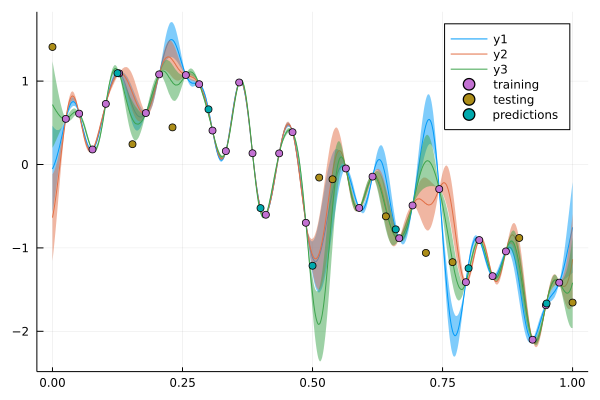

In [37]:
scatter!(x_pred, y_pred; label = "predictions")